# import

In [1]:
import os

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from konlpy.tag import Mecab
import pandas as pd
import sentencepiece as spm
from tensorflow import keras
import matplotlib.pyplot as plt

%matplotlib inline

# Data

In [2]:
train_data = os.getenv("HOME") + '/aiffel/sentiment_classification/ratings_train.txt'
test_data = os.getenv("HOME") + '/aiffel/sentiment_classification/ratings_test.txt'

train = pd.read_csv(train_data, sep = '\t', quoting = 3)
test = pd.read_csv(test_data, sep = '\t', quoting = 3)


In [3]:
train = train.dropna() #결측값 제거
test = test.dropna()

print(train.shape)
print(test.shape)

(149995, 3)
(49997, 3)


In [4]:
y_train = train['label']
y_test = test['label']

In [5]:
with open(train_data, 'w', encoding='utf8') as f:
    f.write('\n'.join(train['document']))


with open(train_data, 'r', encoding = 'utf-8') as f:
    X_train = f.read().split('\n')
    

with open(test_data, 'w', encoding = 'utf-8') as f2:
    f2.write('\n'.join(test['document']))

with open(test_data, 'r', encoding = 'utf-8') as f:
    X_test = f.read().split('\n')    

# SentencePiece 토큰화

In [6]:
vocab_size = 8000

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(train_data, vocab_size)    
)
!ls -l korean_spm*

-rw-r--r-- 1 aiffel aiffel 374677 10월 21 14:50 korean_spm.model
-rw-r--r-- 1 aiffel aiffel 144164 10월 21 14:50 korean_spm.vocab


In [7]:
sp = spm.SentencePieceProcessor()
sp.load('korean_spm.model')

True

In [8]:
def sp_tokenize(sp, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(sp.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [9]:
train_tensor, train_word_index, train_index_word = sp_tokenize(sp, X_train)
test_tensor, test_word_index, test_index_word = sp_tokenize(sp, X_test)

# 모델

In [10]:
word_vector_dim = 16 #하이퍼파라미터

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(32, return_sequences = True))
model.add(keras.layers.SpatialDropout1D(0.4))
model.add(keras.layers.Dense(1, activation='sigmoid'))


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          128000    
_________________________________________________________________
lstm (LSTM)                  (None, None, 32)          6272      
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 32)          0         
_________________________________________________________________
dense (Dense)                (None, None, 1)           33        
Total params: 134,305
Trainable params: 134,305
Non-trainable params: 0
_________________________________________________________________


In [12]:
#validation set 
X_val = train_tensor[:15000]   
y_val = y_train[:15000]

partial_X_train = train_tensor[15000:]  
partial_y_train = y_train[15000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(134995, 134)
(134995,)


# 모델 학습

In [13]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=8 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/8
264/264 [==============================] - 3s 10ms/step - loss: 0.5263 - accuracy: 0.7283 - val_loss: 0.3902 - val_accuracy: 0.8333
Epoch 2/8
264/264 [==============================] - 2s 8ms/step - loss: 0.3713 - accuracy: 0.8443 - val_loss: 0.3617 - val_accuracy: 0.8410
Epoch 3/8
264/264 [==============================] - 2s 8ms/step - loss: 0.3509 - accuracy: 0.8526 - val_loss: 0.3538 - val_accuracy: 0.8423
Epoch 4/8
264/264 [==============================] - 2s 8ms/step - loss: 0.3402 - accuracy: 0.8568 - val_loss: 0.3552 - val_accuracy: 0.8424
Epoch 5/8
264/264 [==============================] - 2s 8ms/step - loss: 0.3357 - accuracy: 0.8581 - val_loss: 0.3650 - val_accuracy: 0.8436
Epoch 6/8
264/264 [==============================] - 2s 9ms/step - loss: 0.3321 - accuracy: 0.8593 - val_loss: 0.3507 - val_accuracy: 0.8436
Epoch 7/8
264/264 [==============================] - 2s 8ms/step - loss: 0.3286 - accuracy: 0.8612 - val_loss: 0.3498 - val_accuracy: 0.8430
Epoch 8/8
26

# 시각화

In [14]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


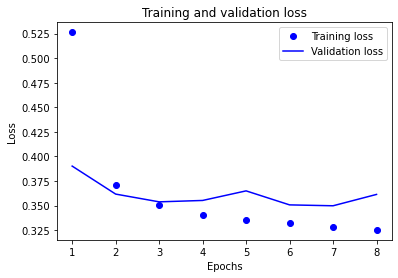

In [15]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [16]:
results = model.evaluate(test_tensor,  y_test, verbose=2)

print(results)

1563/1563 - 3s - loss: 0.3795 - accuracy: 0.8332
[0.379489004611969, 0.8332124352455139]


# Conclusion

[Word2Vec와의 비교](https://github.com/silvermaking/Aiffel/blob/master/E9.ipynb)   
- 

정확도는 83%정도로 word2vec정도 나왔다. 